In [1]:
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Import packages that will be used
import c2qa
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RGate

In [ ]:
# To prepare a cat state, we first set our initial parameters: we need one qumode and one ancillary qubit. We will also
# need to set a cutoff for our qumode.
Nmodes = 1
Nqubits = 1
cutoff = 2**16 # The photon number at which to truncate the Hilbert space. Our basis will consist of Fock states |0> to |cutoff-1>
alpha = 3/np.sqrt(2)

# Instantiate the Qumode register
qmr = c2qa.QumodeRegister(num_qumodes=Nmodes, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))

# Instantiate a Qubit and Classical register
qbr = QuantumRegister(Nqubits)
cbr = ClassicalRegister(Nqubits)

# Initialize a CVCircuit, which includes both the qumode register as well as the qubit register
circuit = c2qa.CVCircuit(qmr, qbr, cbr)

# Compose cat state prep circuit
circuit.h(qbr[0])
circuit.cv_c_d(alpha,qmr[0],qbr[0])
circuit.h(qbr[0])
circuit.measure(qbr[0],cbr[0])

# # Compose cat state prep circuit for second qumode 
# circuit.h(qbr[1])
# circuit.cv_c_d(alpha,qmr[1],qbr[1])
# circuit.h(qbr[1])
# circuit.measure(qbr[1],cbr[1])

# Now draw the circuit using Qiskit's draw() function
circuit.draw(scale=1, output = 'mpl', fold = 32)

In [ ]:
# Now simulate the circuit to retrieve the final density matrix.
stateop, _ = c2qa.util.simulate(circuit)

# print(stateop)

# from qiskit.quantum_info import DensityMatrix, partial_trace
# from qiskit.quantum_info import Statevector

# Convert the state vector to a density matrix
# density_matrix = DensityMatrix(stateop)
# print(density_matrix)

# Perform the partial trace operation
# stateop_1 = partial_trace(density_matrix, [1]).to_statevector()
# stateop_2 = partial_trace(density_matrix, [0]).to_statevector()

# Use Bosonic Qiskit's built-in plot_wigner function, which traces out the qubit and displays the Wigner (phase-space) 
# representation of the qumode state.
# For the first qumode
# stateop_1 = stateop.partial_trace([1]) # Tracing out the second qumode
# print(stateop_1)
fig1 = c2qa.wigner.plot_wigner(circuit, stateop, dpi = 300)


# For the second qumode
# stateop_2 = stateop.partial_trace([0]) # Tracing out the first qumode
# fig2 = c2qa.wigner.plot_wigner(circuit, stateop_2, dpi = 300)
# c2qa.util.stateread(stateop_2, 1, 1, cutoff)

In [ ]:
from qiskit.quantum_info import DensityMatrix, partial_trace
density_matrix = DensityMatrix(stateop)
stateop_1 = partial_trace(density_matrix, []).to_statevector()
stateop_1.data
fig1 = c2qa.wigner.plot_wigner(circuit, stateop_1, dpi = 300)

In [ ]:
# We can also print out the occupancy of the modes and their complex amplitudes.
c2qa.util.stateread(stateop,1,1,cutoff);

#### Initiate two qumodes and apply beamsplitter

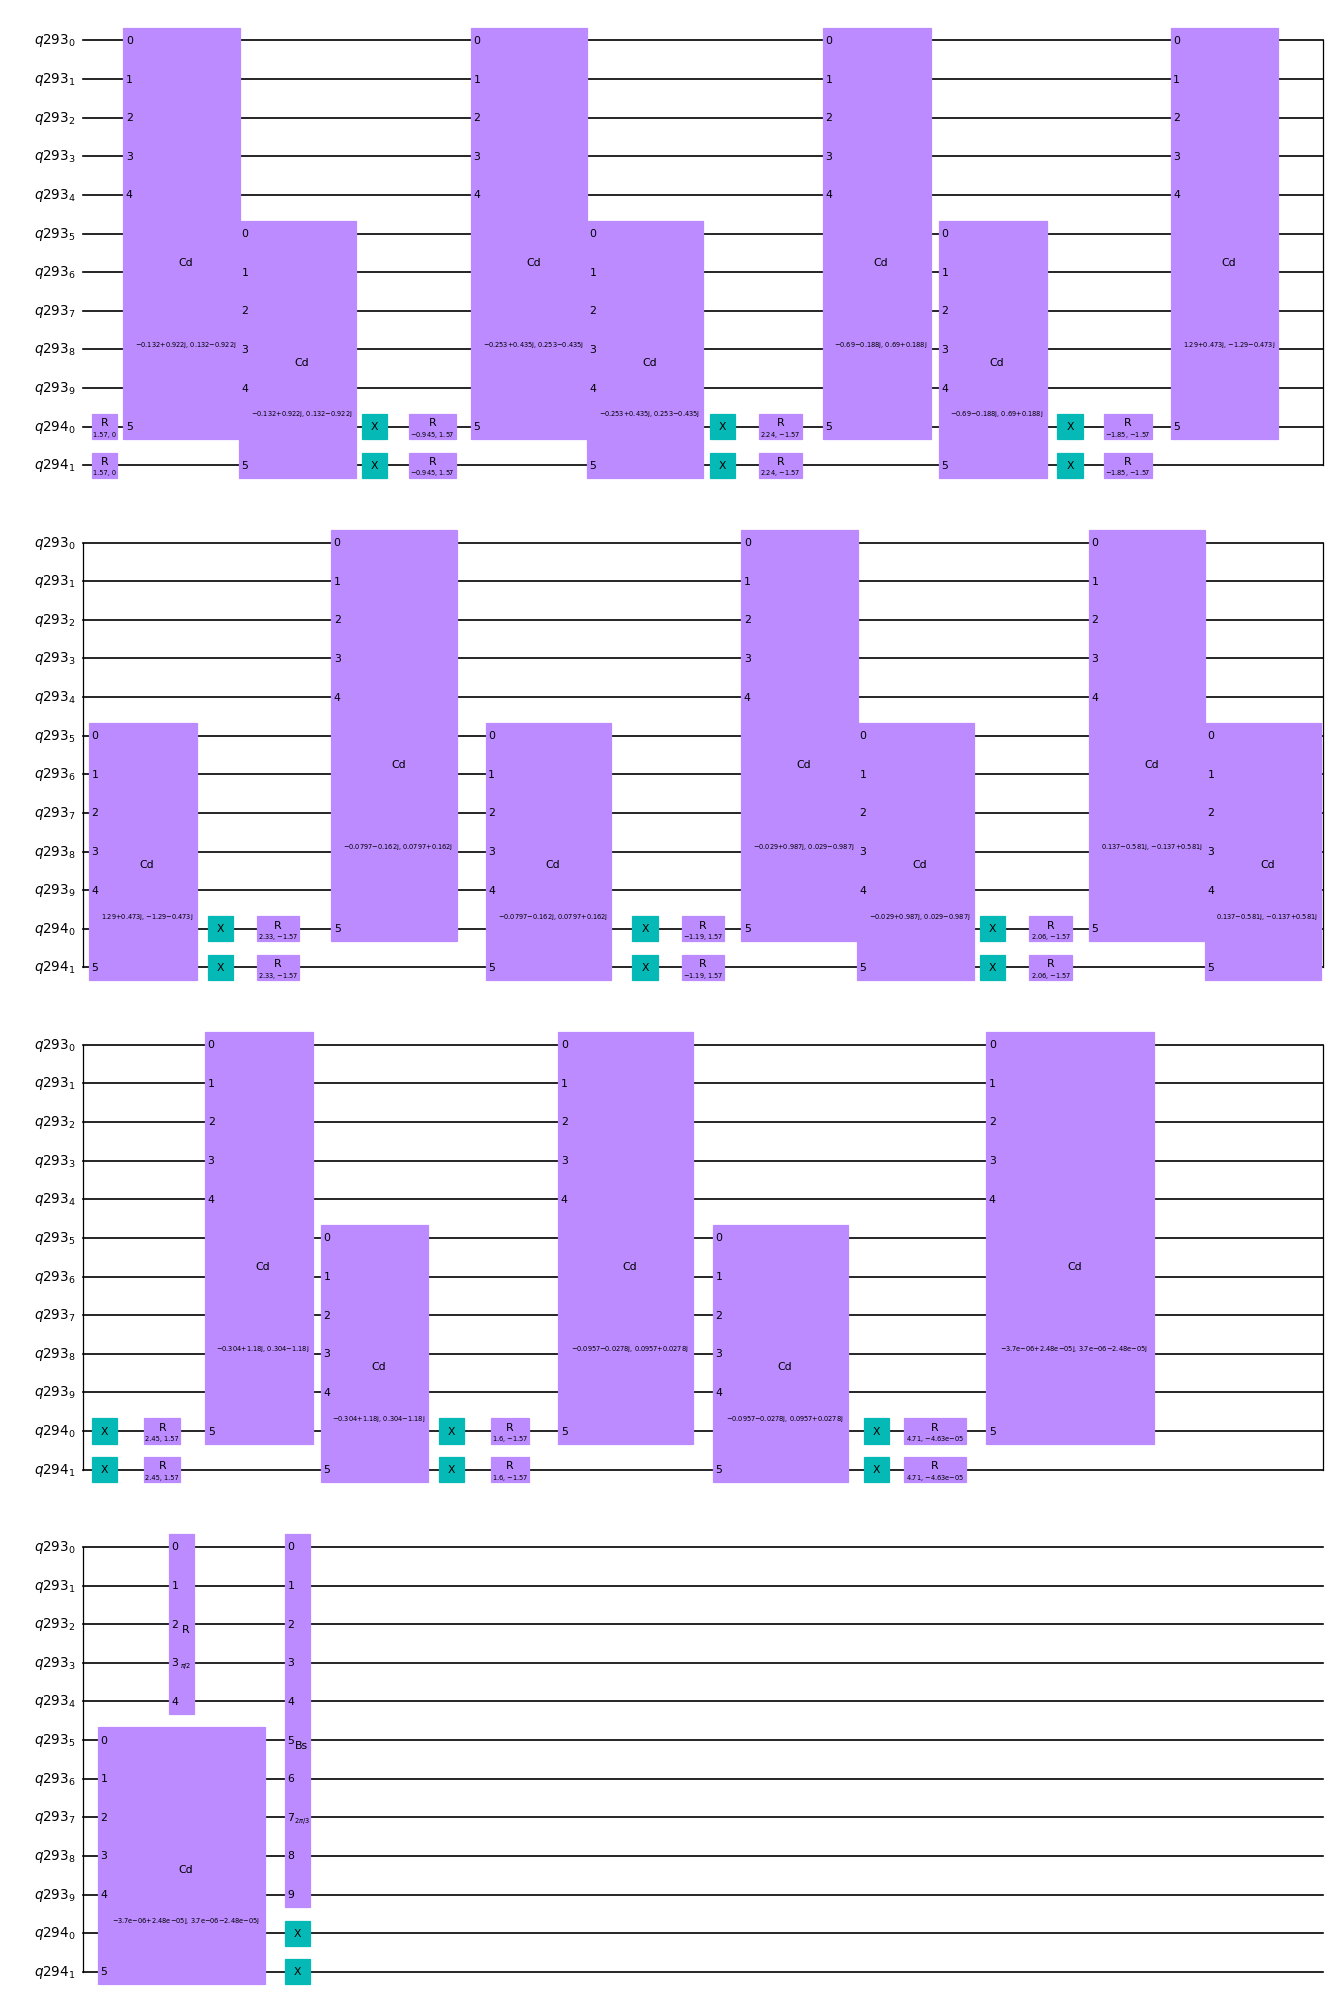

In [46]:
# Let's first import the GKP parameters
GKP_params = np.load('GKP_params.npz')

# Set some initial parameters:
Nmodes = 2 # The number of qumodes
Nqubits = 2 # The number of qubits
cutoff = 2**5 # The qumode cutoff

# Instantiate the Qumode register
qmr = c2qa.QumodeRegister(num_qumodes=Nmodes, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))

# Instantiate a Qubit register
qbr = QuantumRegister(Nqubits)

# Initialize a CVCircuit, which includes both the qumode register as well as the qubit register
circuit = c2qa.CVCircuit(qmr, qbr)

# Now append gates to the circuit. Here, we append multiple layers, each with a single qubit RGate, followed by
# a conditional displacement and an X gate (which together form the "echoed-conditional displacement" -- for more info,
# see https://www.nature.com/articles/s41567-022-01776-9.
for beta, phi, theta in zip(GKP_params['betas'], GKP_params['phis'], GKP_params['thetas']):
    circuit.append(RGate(theta,phi),[qbr[0]])
    circuit.cv_c_d(beta/2,qmr[0],qbr[0])
    circuit.x(qbr[0])



    
theta = 1 * np.pi/2
circuit.cv_r(theta, qmr[0])


for beta, phi, theta in zip(GKP_params['betas'], GKP_params['phis'], GKP_params['thetas']):
    circuit.append(RGate(theta,phi),[qbr[1]])
    circuit.cv_c_d(beta/2,qmr[1],qbr[1])
    circuit.x(qbr[1])

theta = 2 * np.pi/3

circuit.cv_bs(theta, qmr[0], qmr[1])
    
# Now draw the circuit using Qiskit's draw() function
circuit.draw(scale=0.6, output = 'mpl', fold = 32)

In [47]:
stateop, _ = c2qa.util.simulate(circuit)

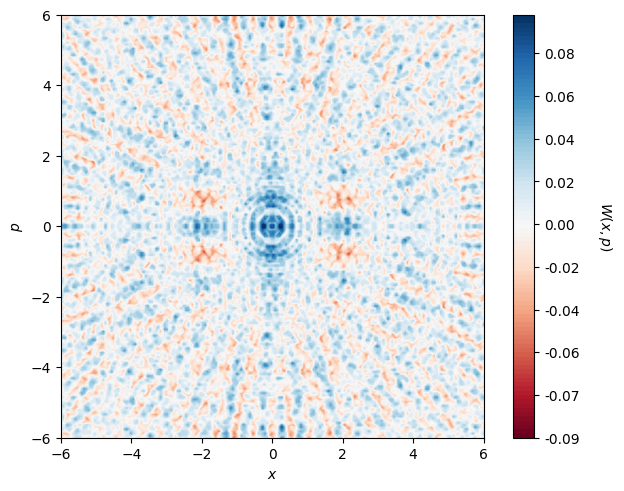

In [48]:
axes_min = -6
axes_max = 6
axes_steps = 200
trace = True
file = None
num_colors = 100
draw_grid = False
dpi = 100

c2qa.wigner.plot_wigner(
        circuit,
        stateop,
        axes_min=axes_min,
        axes_max=axes_max,
        axes_steps=axes_steps,
        dpi = 300
    )